## Hyperparameter Optimization of the Bayesian SOT

This code retrieves a surface map from reflection integrated light curve of an Earth analog.

- Kawahara 2020b

See also
- Farr et al. 2018 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  You need Healpy, Scikit-learn, sot package https://github.com/HajimeKawahara/sot.
Add sot/sot/core in your PYTHONPATH.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
import mocklc #Use mocklc module in sot package. 
import runstatic_cpu as runstatic
import scipy

In [3]:
#set geometry
inc=45.0/180.0*np.pi
Thetaeq=np.pi
#zeta=np.pi/3.0
zeta=23.4/180.0*np.pi                                                                                               
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
Porb=365.242190402                                            
#Porb=40.0
worb=2*np.pi/Porb                                                                                                                
Ni=1024
obst=np.linspace(0.0,Porb,Ni)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


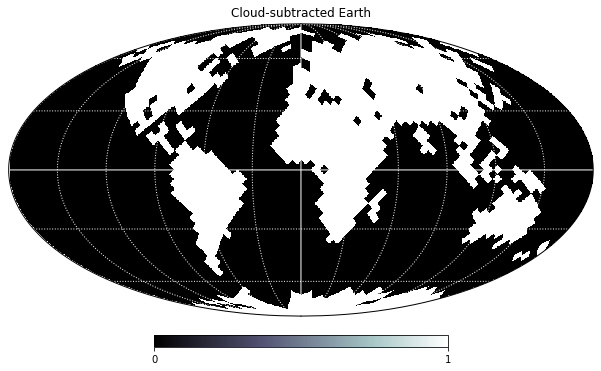

In [4]:
# test map
nside=16
mmap=hp.read_map("/home/kawahara/exomap/sot/data/mockalbedo16.fits")
mask=(mmap>0.0)
mmap[mask]=1.0
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [5]:
#generating light curve
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)
WI,WV=mocklc.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)
W=WV[:,:]*WI[:,:]
lc=np.dot(W,mmap)

sigma=np.mean(lc)*0.01
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

No handles with labels found to put in legend.


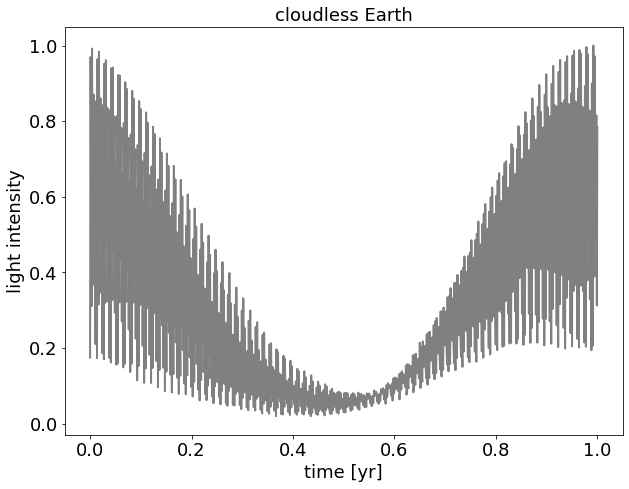

In [6]:
fig= plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


## RBF kernel

In [7]:
import sepmat 
import gpkernel 
import runstatic_cpu as runstatic

In [8]:
sep=sepmat.calc_sepmatrix(nside)

In [9]:
ts=time.time()
#Rough GRID search for maximum evidence    
alphalist=np.logspace(-2,2,10)
gamlist=np.linspace(np.pi/1000,50.0/180.0*np.pi,10)
evarray=np.zeros((len(gamlist),len(alphalist)))

for i,gamma in enumerate((gamlist)):
    for j,alpha in enumerate((alphalist)):
        #print(gamma)                                                
        KS=alpha*gpkernel.RBF(sep,gamma)
    #Compute negative log evidence                                          
        try:
            nlev=runstatic.STSOT_evidence(W,KS,lc,sigma)
            evarray[i,j]=nlev
        except:
            evarray[i,j]=None

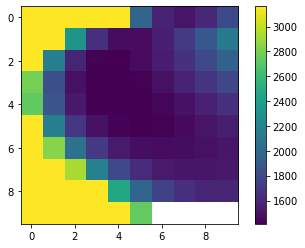

In [10]:
c=plt.imshow(evarray,vmin=10**3.15,vmax=10**3.5)
plt.colorbar(c)

In [11]:
i,j=np.unravel_index(np.nanargmin(evarray, axis=None), evarray.shape)
gam0=gamlist[i]
alpha0=alphalist[j]
print("gam,alpha,val")
print(gam0,alpha0,evarray[i,j])

gam,alpha,val
0.3895962741396231 0.5994842503189409 1377.8180670087575


## optimization by quasi Newton

In [23]:

def func(x):
    gam_acute,alpha_acute=x
    gamma=np.exp(gam_acute)
    alpha=np.exp(alpha_acute)
    KS=alpha*gpkernel.RBF(sep,gamma)
    nlev=runstatic.STSOT_evidence(W,KS,lc,sigma)
    return nlev

def jac(x):
    gam_acute,alpha_acute=x
    alpha=np.exp(alpha_acute)
    gamma=np.exp(gam_acute)
    KS=alpha*gpkernel.RBF(sep,gamma)                   
    dKc=[alpha*gpkernel.d_RBF(sep,gamma),1.0]                                 
    grad=runstatic.STSOT_DL(W,KS,dKc,lc,sigma)
    return grad

In [24]:
x0=[np.log(gam0),np.log(alpha0)]
res=scipy.optimize.minimize(func,x0,method="L-BFGS-B",jac=jac,tol=1.e-12)

gamast=np.exp(res["x"][0])
alphaast=np.exp(res["x"][1])
print("gamma,alpha=",gamast/np.pi*180,"deg",alphaast)
print("gamma,alpha=",gamast,"radian",alphaast)

gamma,alpha= 18.604282016624346 deg 0.4172890000949949
gamma,alpha= 0.32470597615966523 radian 0.4172890000949949


## (optional) show an evidence map again for the paper (very long)

In [14]:
alphalist=np.logspace(-2,2,50)
gamlist=np.linspace(np.pi/1000,50.0/180.0*np.pi,50)
evarray=np.zeros((len(gamlist),len(alphalist)))

for i,gamma in enumerate((gamlist)):
    for j,alpha in enumerate((alphalist)):
        #print(gamma)                                                
        KS=alpha*gpkernel.RBF(sep,gamma)
    #Compute negative log evidence                                          
        try:
            nlev=runstatic.STSOT_evidence(W,KS,lc,sigma)
            evarray[i,j]=nlev
        except:
            evarray[i,j]=None

In [22]:
dat=np.load("evgrid_sotrbf.npz")
evarray=dat["arr_0"]
alphalist=dat["arr_1"]
gamlist=dat["arr_2"]

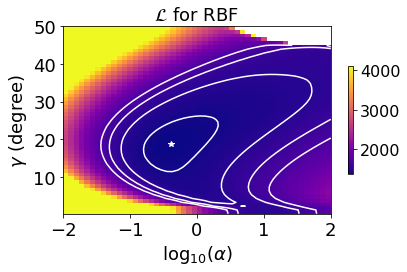

In [30]:
X, Y=pylab.meshgrid(np.log10(alphalist), gamlist)
Y=Y/np.pi*180
fig=plt.figure()
ax=fig.add_subplot(111)
c=plt.imshow(evarray,extent=[np.log10(alphalist[0]),np.log10(alphalist[-1]),(gamlist[-1])/np.pi*180.0,(gamlist[0])/np.pi*180.0],cmap="plasma",vmin=np.nanmin(evarray)\
,vmax=np.nanmin(evarray)*3)
cbar=plt.colorbar(c,shrink=0.5)
cs=plt.contour(X, Y, evarray,[1400,1500,1600,1700],colors='white', linestyles='solid')
plt.plot([np.log10(alphaast)],[gamast/np.pi*180],"*",color="white")
ax.set_aspect(0.7/ax.get_data_ratio())
plt.ylabel("$\\gamma$ (degree)",fontsize=18)
plt.xlabel("$\\log_{10} (\\alpha$)",fontsize=18)
plt.title("$\\mathcal{L}$ for RBF",fontsize=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=16)
plt.gca().invert_yaxis()
plt.savefig("evgrid_sotrbf.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [16]:
#np.savez("evgrid_sotrbf",evarray,alphalist, gamlist)

## Matern -3/2

In [31]:
def func(x):
    gam_acute,alpha_acute=x
    gamma=np.exp(gam_acute)
    alpha=np.exp(alpha_acute)
    KS=alpha*gpkernel.Matern32(sep,gamma)
    nlev=runstatic.STSOT_evidence(W,KS,lc,sigma)
    return nlev

def jac(x):
    gam_acute,alpha_acute=x
    alpha=np.exp(alpha_acute)
    gamma=np.exp(gam_acute)
    KS=alpha*gpkernel.Matern32(sep,gamma)                   
    dKc=[alpha*gpkernel.d_Matern32(sep,gamma),1.0]                                 
    grad=runstatic.STSOT_DL(W,KS,dKc,lc,sigma)
    return grad

In [32]:
x0=[np.log(gam0),np.log(alpha0)]
res=scipy.optimize.minimize(func,x0,method="L-BFGS-B",jac=jac,tol=1.e-12)

gamast=np.exp(res["x"][0])
alphaast=np.exp(res["x"][1])
print("gamma,alpha=",gamast/np.pi*180,"deg",alphaast)
print("gamma,alpha=",gamast,"radian",alphaast)

gamma,alpha= 26.526947492919255 deg 0.4775753187200252
gamma,alpha= 0.4629825742550962 radian 0.4775753187200252


In [19]:
alphalist=np.logspace(-2,2,50)
gamlist=np.linspace(np.pi/1000,50.0/180.0*np.pi,50)
evarray=np.zeros((len(gamlist),len(alphalist)))

for i,gamma in enumerate((gamlist)):
    for j,alpha in enumerate((alphalist)):
        #print(gamma)                                                
        KS=alpha*gpkernel.Matern32(sep,gamma)
    #Compute negative log evidence                                          
        try:
            nlev=runstatic.STSOT_evidence(W,KS,lc,sigma)
            evarray[i,j]=nlev
        except:
            evarray[i,j]=None

In [33]:
dat=np.load("evgrid_sotmatern.npz")
evarray=dat["arr_0"]
alphalist=dat["arr_1"]
gamlist=dat["arr_2"]

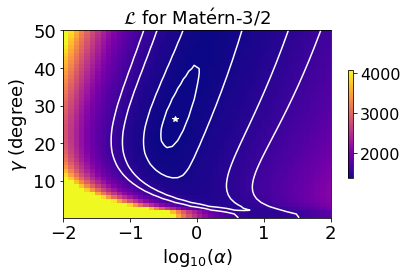

In [40]:
X, Y=pylab.meshgrid(np.log10(alphalist), gamlist)
Y=Y/np.pi*180
fig=plt.figure()
ax=fig.add_subplot(111)
c=plt.imshow(evarray,extent=[np.log10(alphalist[0]),np.log10(alphalist[-1]),(gamlist[-1])/np.pi*180.0,(gamlist[0])/np.pi*180.0],cmap="plasma",vmin=np.nanmin(evarray)\
,vmax=np.nanmin(evarray)*3)
cbar=plt.colorbar(c,shrink=0.5)
cs=plt.contour(X, Y, evarray,[1370,1400,1500,1600],colors='white', linestyles='solid')
plt.plot([np.log10(alphaast)],[gamast/np.pi*180],"*",color="white")
ax.set_aspect(0.7/ax.get_data_ratio())
plt.ylabel("$\\gamma$ (degree)",fontsize=18)
plt.xlabel("$\\log_{10} (\\alpha$)",fontsize=18)
plt.title("$\\mathcal{L}$ for Mat$\\acute{\mathrm{e}}$rn-3/2",fontsize=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=16)
plt.gca().invert_yaxis()
plt.savefig("evgrid_sotmatern.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [21]:
#np.savez("evgrid_sotmatern",evarray,alphalist, gamlist)